### **2. Modelo de Optimización de Precios**

Finalizado el análisis y con las interiorizaciones obtenidas, procedemos 
a crear el modelo para la optimización de precios, donde debemos contemplar 
primero el efecto combinado de precios y cantidad. Esto debido a que nos 
guiaremos del concepto de que que ambas métricas se relacionan. Entonces:
$$
D = D_0*(\frac{P}{P_0})^e
$$
Donde
- $D$ = Demanda
- $D_0$ = Demanda pronosticada
- $P_0$ = Precio actual
- $e$ = coeficiente de elasticidad

Podemos despejar $e$ de manera que:
$$
(\frac{D}{D_0}) = (\frac{P}{P_0})^e => e = \frac{log(\frac{D}{D_0})}{log(\frac{P}{P_0})}
$$

La demanda no depende exclusivamente del precio, debido a que deberiamos 
considerar a la competencia, productos sustitutos y complementarios, etc. 

Los siguientes pasos fueron tomados en esta libreta:

1. Preparar los datos
2. Graficar el efecto de demanda por precio, asumiendo otros efectos estáticos
3. Predecir la demanda para un periodo según solicitado
4. Calcular el mejor nivel de precios y el revenue esperado

In [1]:
# Step 0. Load libraries and custom functions
# Dataframes, vectors & matrices
import pandas as pd
import numpy as np
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Statistics
import scipy.stats as scp_stats
import statsmodels.api as sm
# Time series
import darts
from darts.models import ExponentialSmoothing

/Users/alexismena/Documents/Data_Projects/Python/Pricing_Model/.venv/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


Procederemos a la carga de los datos y a un vistazo a los mismos:

In [2]:
# Step 1. Load dataset
# 1.1 Read csv and get basic info
df_raw = pd.read_csv('../data/ventas_final.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10879 entries, 0 to 10878
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fecha_Formato     10879 non-null  object 
 1   Fecha             10879 non-null  object 
 2   Codigo            10879 non-null  int64  
 3   Descripcion       10879 non-null  object 
 4   Precio_Unitario   10879 non-null  float64
 5   Costo_Unitario    10879 non-null  float64
 6   Cantidad_Vendida  10879 non-null  float64
 7   Ganancia          10879 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 680.1+ KB


In [3]:
# 1.2 Get a sample
df_raw.sample(5, random_state=2024)

,Fecha_Formato,Fecha,Codigo,Descripcion,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Ganancia
10849,2024-02-05,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0,1.10
3320,2023-01-30,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0,26.10
1150,2022-10-17,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0,0.50
7147,2022-10-24,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0,7.84
6449,2023-06-19,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0,51.95


Debido a que grabamos los datos en formato csv en el anterior notebook, 
debemos darle el formato y establecer el índice con las fechas.

In [4]:
# 1.3 Transform the data as in the previous notebook
df_interim = df_raw.copy()
idx = pd.DatetimeIndex(df_interim['Fecha_Formato'])
df_interim = df_interim.set_index(idx)
df_interim = df_interim.drop(columns=['Fecha_Formato'])
df_interim['Codigo'] = df_interim['Codigo'].astype(str)
df_interim.sample(5, random_state=2024)

,Fecha,Codigo,Descripcion,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Ganancia
Fecha_Formato,,,,,,,
2024-02-05,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0,1.10
2023-01-30,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0,26.10
2022-10-17,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0,0.50
2022-10-24,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0,7.84
2023-06-19,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0,51.95


Luego tendremos nuestro dataset final

In [5]:
# 1.4 Create a copy
df = df_interim.copy()

Ahora procederemos a analizar como se comporta el precio con la demanda. 
Para ello haremos una gráfica por cada producto, y haremos una regresión 
lineal en cada uno, evaluando el índice de correlación y el p-value, el 
cual estableceremos como $\alpha$=0.05 como corte para la decisión.

Figura 1. Diagrama de demanda precio por producto


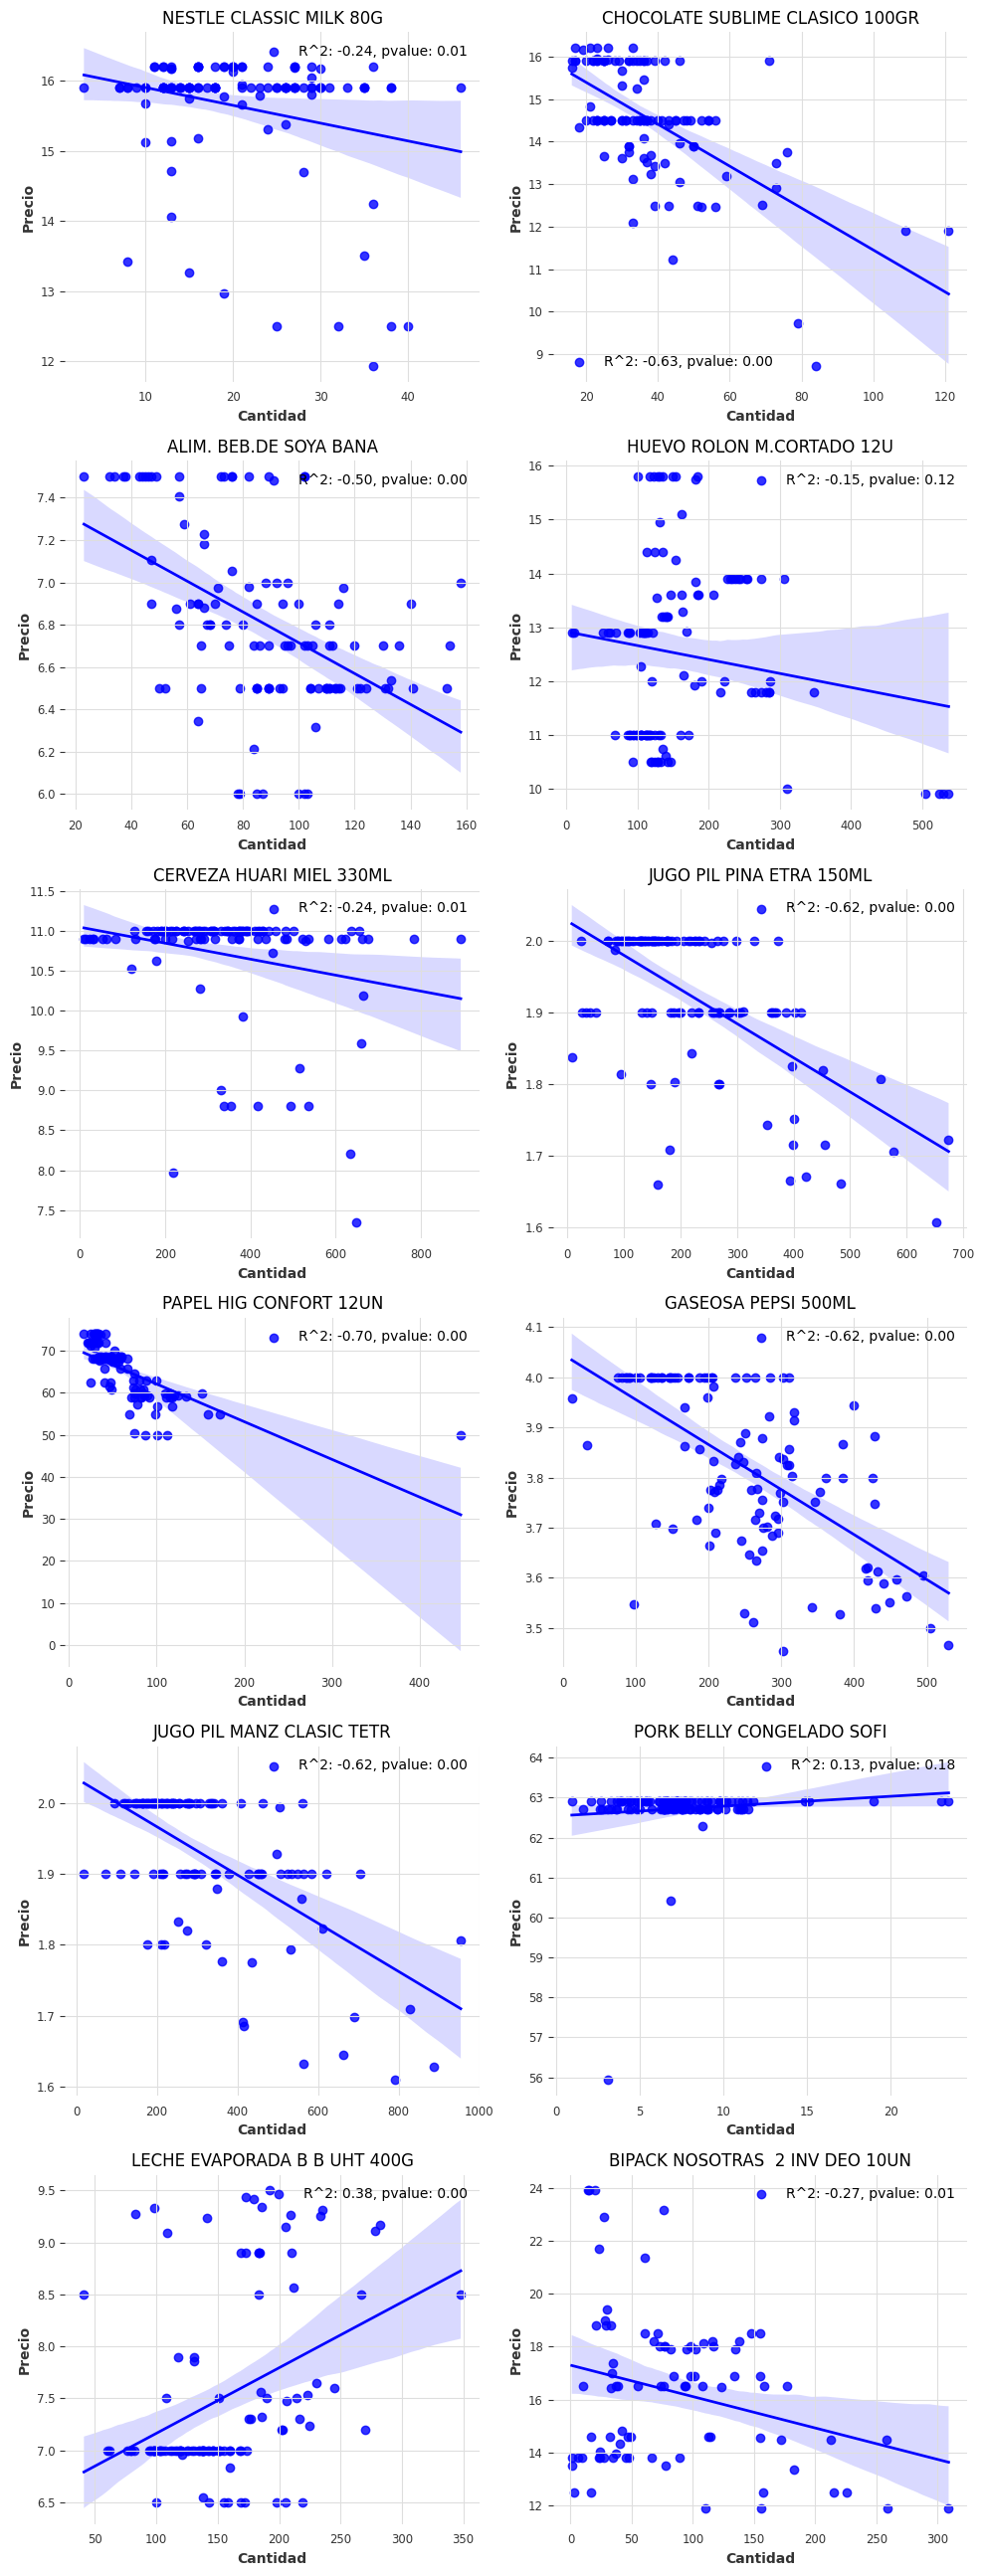

In [6]:
# Step 2. Analizar el efecto demanda precio
# 2.1 Correlación demanda-precio
print('Figura 1. Diagrama de demanda precio por producto')
elasticities = {}
intercepts = {}
costos = {}
categories = df['Descripcion'].unique().tolist()
fig, axs = plt.subplots(6,2,figsize=(10,26))
for i, ax in enumerate(axs.flatten()):
    temp_df = df[df['Descripcion']==categories[i]].copy()
    temp_df['QP'] = temp_df['Cantidad_Vendida'] * temp_df['Precio_Unitario']
    temp_df['Avg_Cost'] = temp_df.groupby(temp_df.index)['Costo_Unitario'].transform('mean')
    temp_df['Precio_Medio'] = temp_df.groupby(temp_df.index)['QP'].transform('sum') / temp_df.groupby(temp_df.index)['Cantidad_Vendida'].transform('sum')
    seg_df = temp_df.groupby(temp_df.index).\
            agg({'Cantidad_Vendida':'sum', 'Precio_Medio':'mean'})
    r, p = scp_stats.pearsonr(seg_df['Cantidad_Vendida'], seg_df['Precio_Medio'])
    res = scp_stats.linregress(seg_df['Cantidad_Vendida'], seg_df['Precio_Medio'])
    sns.regplot(x='Cantidad_Vendida', 
                y='Precio_Medio', 
                data=seg_df, 
                ax=ax, color='b', label=f'R^2: {r:.2f}, pvalue: {p:.2f}')
    ax.set_title(categories[i])
    ax.legend()
    ax.set_xlabel('Cantidad')
    ax.set_ylabel('Precio')
    costos[categories[i]] = temp_df[temp_df['Descripcion']==categories[i]]['Avg_Cost'].mean()
    elasticities[categories[i]] = res.slope
    intercepts[categories[i]] = res.intercept
plt.tight_layout()
plt.show()

En este caso la expectativa es que si el precio disminuye se incrementa 
la demanda y viceversa. Casi todos los productos tienen esa tendencia, 
excepto la panceta y la leche evaporada. Los productos con mayor correlación 
son el papel hig, el jugo pil manz., la gaseosa pepsi y el jugo pil pina. 
Aquí empieza el cuestionamiento, ya que hay productos que parecen incrementar 
la cantidad demandada conforme se incrementa el precio, sin embargo el 
coeficiente de correlación es bajo, es decir que hay un componente grande 
de varianza que no se puede explicar, como el caso de la leche evaporada.

Ahora procederemos a evaluar como se distribuyen los precios mediante un 
histograma de valores.

Figura 2. Histograma de precios de productos


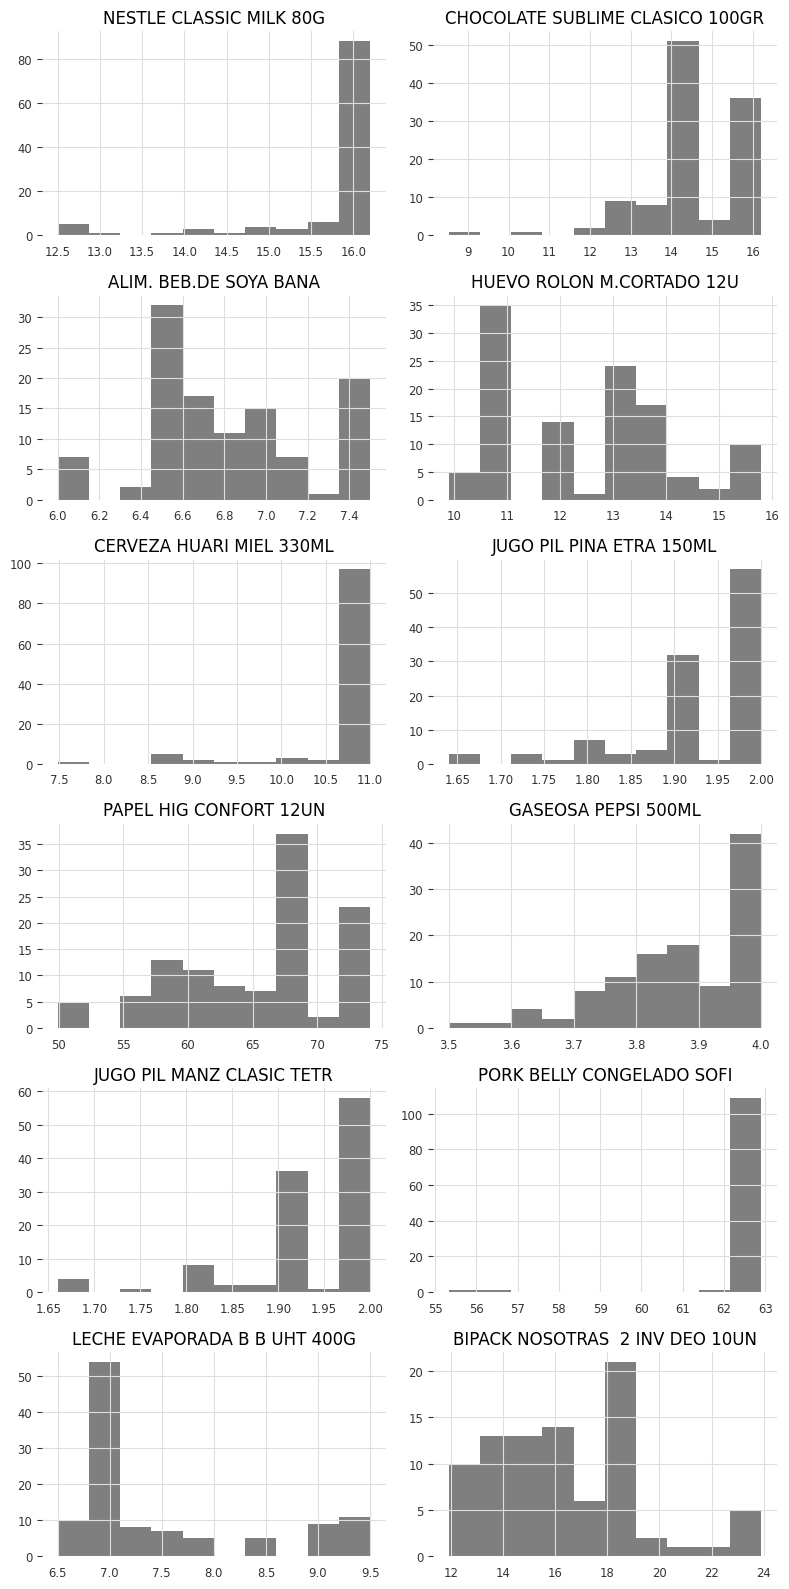

In [7]:
# 2.2 Plot price histogram
print('Figura 2. Histograma de precios de productos')
categories = df['Descripcion'].unique().tolist()
fig, axs = plt.subplots(6,2,figsize=(8,16))
for i, ax in enumerate(axs.flatten()):
    temp_df = df[df['Descripcion']==categories[i]].\
        reset_index().groupby(['Fecha_Formato']).\
            agg({'Cantidad_Vendida':'sum', 'Precio_Unitario':'mean'})
    ax.hist(temp_df['Precio_Unitario'], alpha=0.5, label='Precio')
    ax.set_title(categories[i])
plt.tight_layout()
plt.show()

En el histograma podemos corroborar lo que indicamos en el análisis, esto 
es que ciertos productos son muy estables en precio como el nestle classic 
milk, la panceta de cerdo y la cerveza huari. 

Ahora procederemos a predecir la demanda para la semana 9 del 2024, esto 
es solo un periodo. Debido a los picos de demanda observados, el criterio 
tomado fue de utilizar promedios móviles y tomar el último valor como 
pronóstico para el siguiente periodo, con ello no arriesgamos valores 
extremos.

Figura 3. Cantidad de producto vendido, por semana


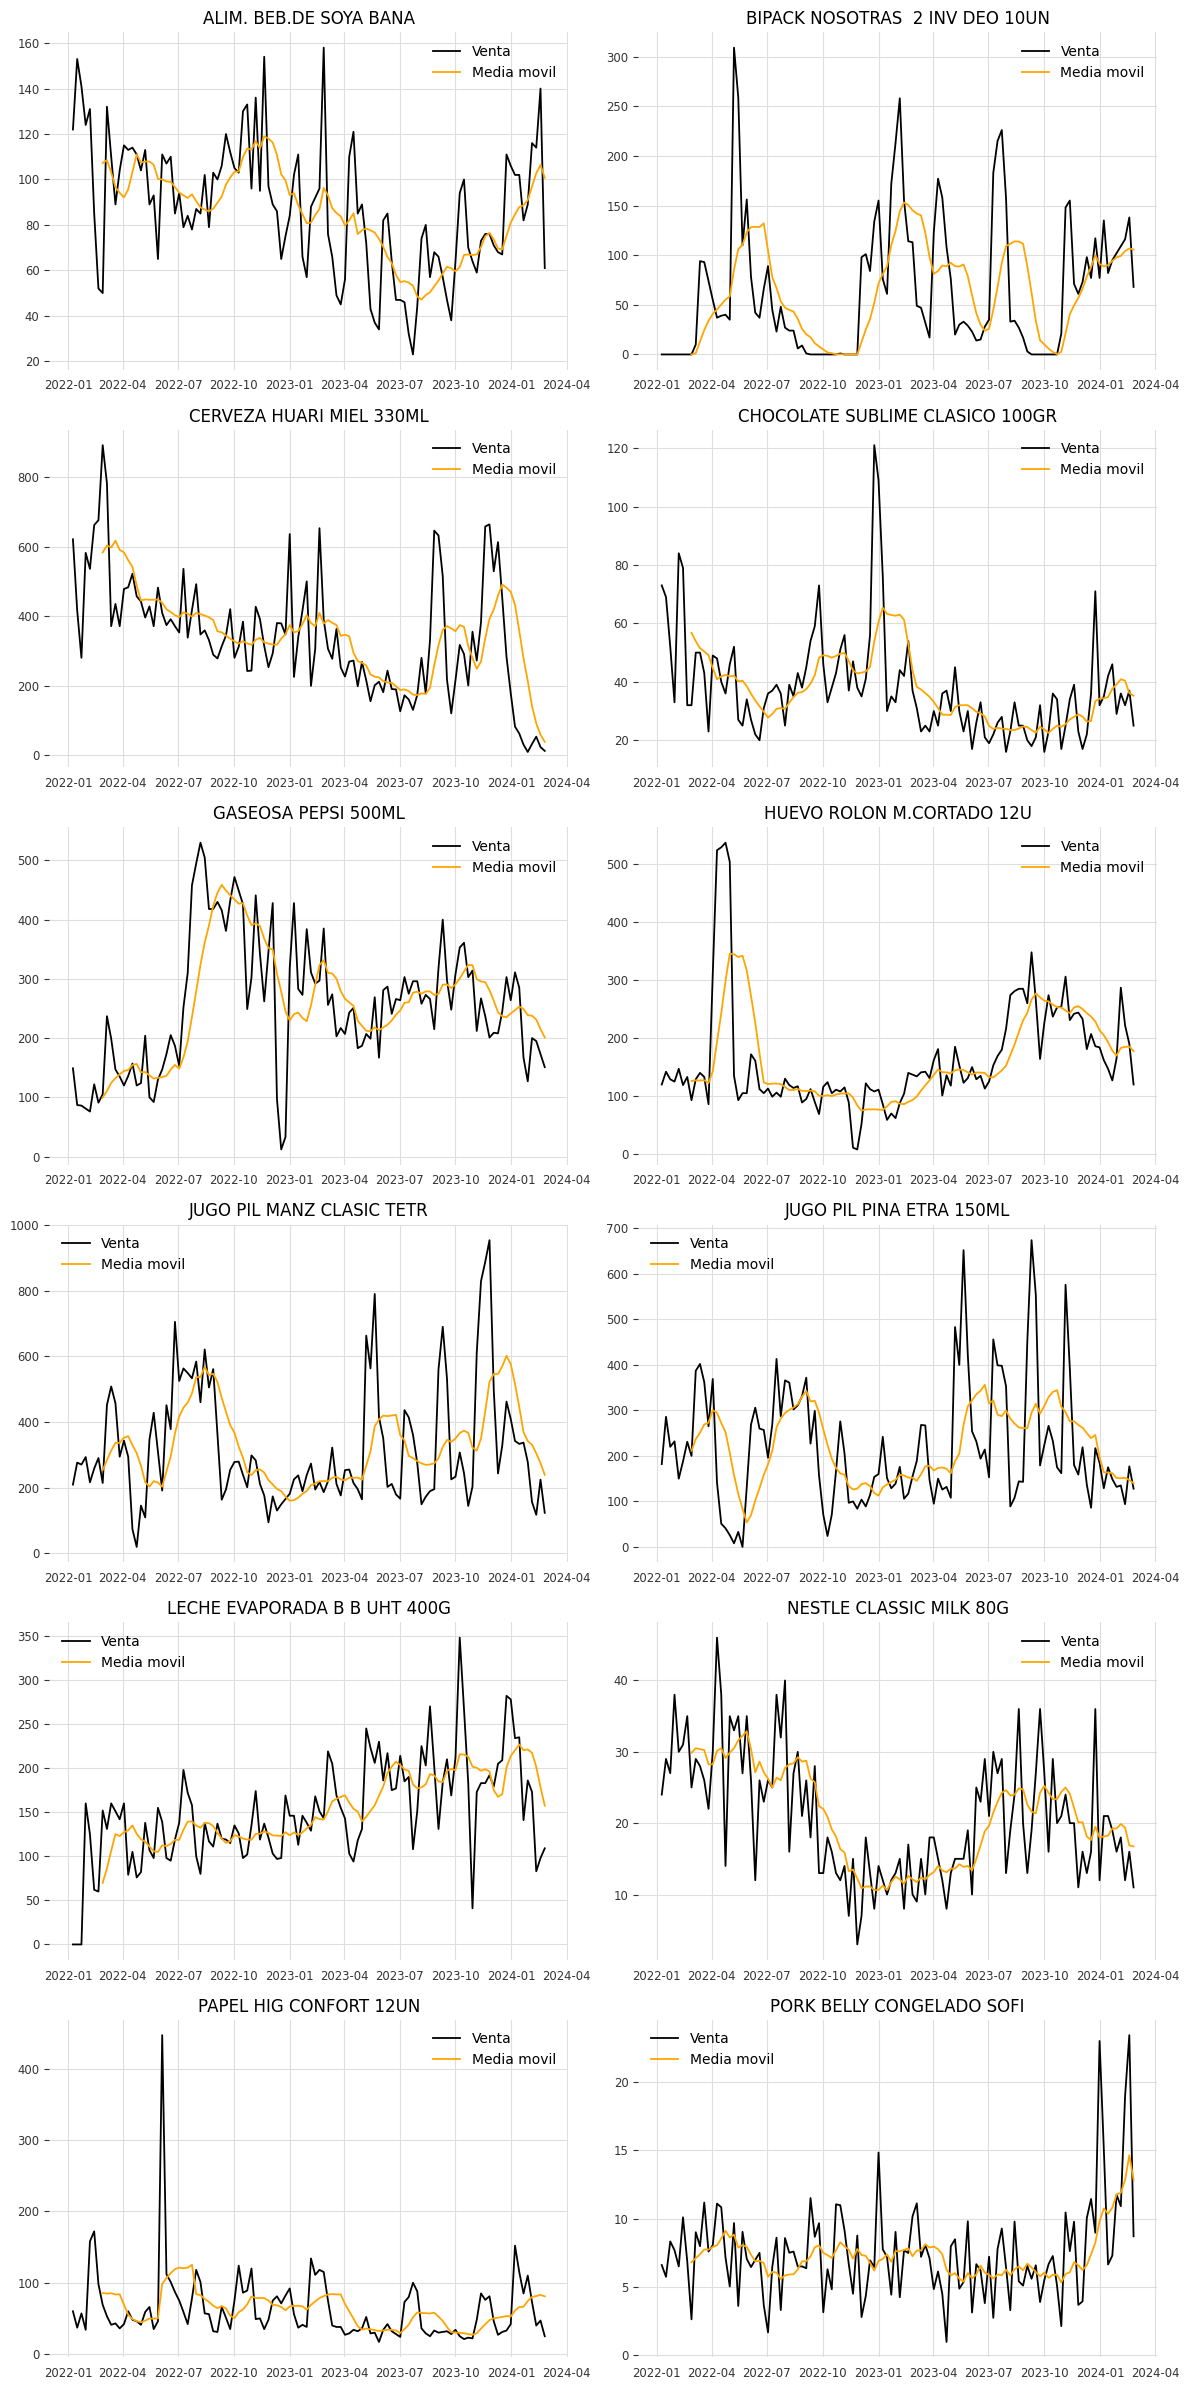

In [8]:
# 3. Predict demand for each product
# 3.1 Plot trends on quantity, by product and week
predictions = {}
df_quantity = df[['Descripcion','Cantidad_Vendida']].pivot_table(
    index=df.index,
    columns='Descripcion',
    values='Cantidad_Vendida',
    aggfunc='sum',
).resample('W', level=0).sum()

print('Figura 3. Cantidad de producto vendido, por semana')
fig, axs = plt.subplots(6,2, figsize=(12,24))
for i, ax in enumerate(axs.flatten()):
    temp_df = df_quantity.iloc[:,i]
    temp_df['rolling'] = temp_df.rolling(8).mean()
    ax.plot(df_quantity.iloc[:,i], label='Venta')
    ax.plot(temp_df['rolling'], c='orange', label='Media movil')
    ax.set_title(df_quantity.columns[i])
    ax.grid(True)
    ax.legend()
    predictions[df_quantity.columns[i]] = round(temp_df['rolling'].iloc[-1],0)
plt.tight_layout()
plt.show()

Las demandas pronosticadas según el procedimiento graficado en la figura 3 
fueron guardadas en un diccionario, de manera que podamos filtrar los 
productos para calcular el mejor nivel de precios.

En esta etapa final, buscaremos el mejor nivel de optimización de precios 
para los productos en base al pronóstico de demanda que hemos hecho en el 
paso anterior. 


In [9]:
# Step 4. Optimization
# 4.1 Create the function for prediction
def predict_quantity(product, df, elasticity, intercept):
    # df_temp will have our price range and estimated quantity
    df_temp = pd.DataFrame()
    # ds is a filtered copy per product
    ds = df[df['Descripcion']==product].reset_index().copy()
    ds['Price_Quant'] = ds['Precio_Unitario']* ds['Cantidad_Vendida']
    ds['Avg_Cost'] = ds.groupby('Fecha_Formato')['Costo_Unitario'].transform('mean')
    ds['Avg_Price'] = ds.groupby("Fecha_Formato")['Price_Quant'].transform('sum') / ds.groupby('Fecha_Formato')['Cantidad_Vendida'].transform('sum')
    # Price range
    start_price = ds[ds['Descripcion']==product]['Avg_Price'].min()
    end_price = ds[ds['Descripcion']==product]['Avg_Price'].max()
    avg_cost = ds[ds['Descripcion']==product]['Avg_Cost'].mean()
    df_temp['price_list'] = np.arange(start_price, end_price, 0.01)
    # Predict quantity
    df_temp['quantity'] =(df_temp['price_list'] - intercept)/elasticity
    df_temp['profit'] = (df_temp['price_list'] - avg_cost)*df_temp['quantity']
    return df_temp

Esta function genera por producto una lista de precios medios desde los 
rangos mínimos/maximos y la demanda esperada en base al ratio de demanda 
y precio (pendiente de la regresión lineal). Con ello podemos generar 
curvas de ganancia y de cantidad versus precio. 

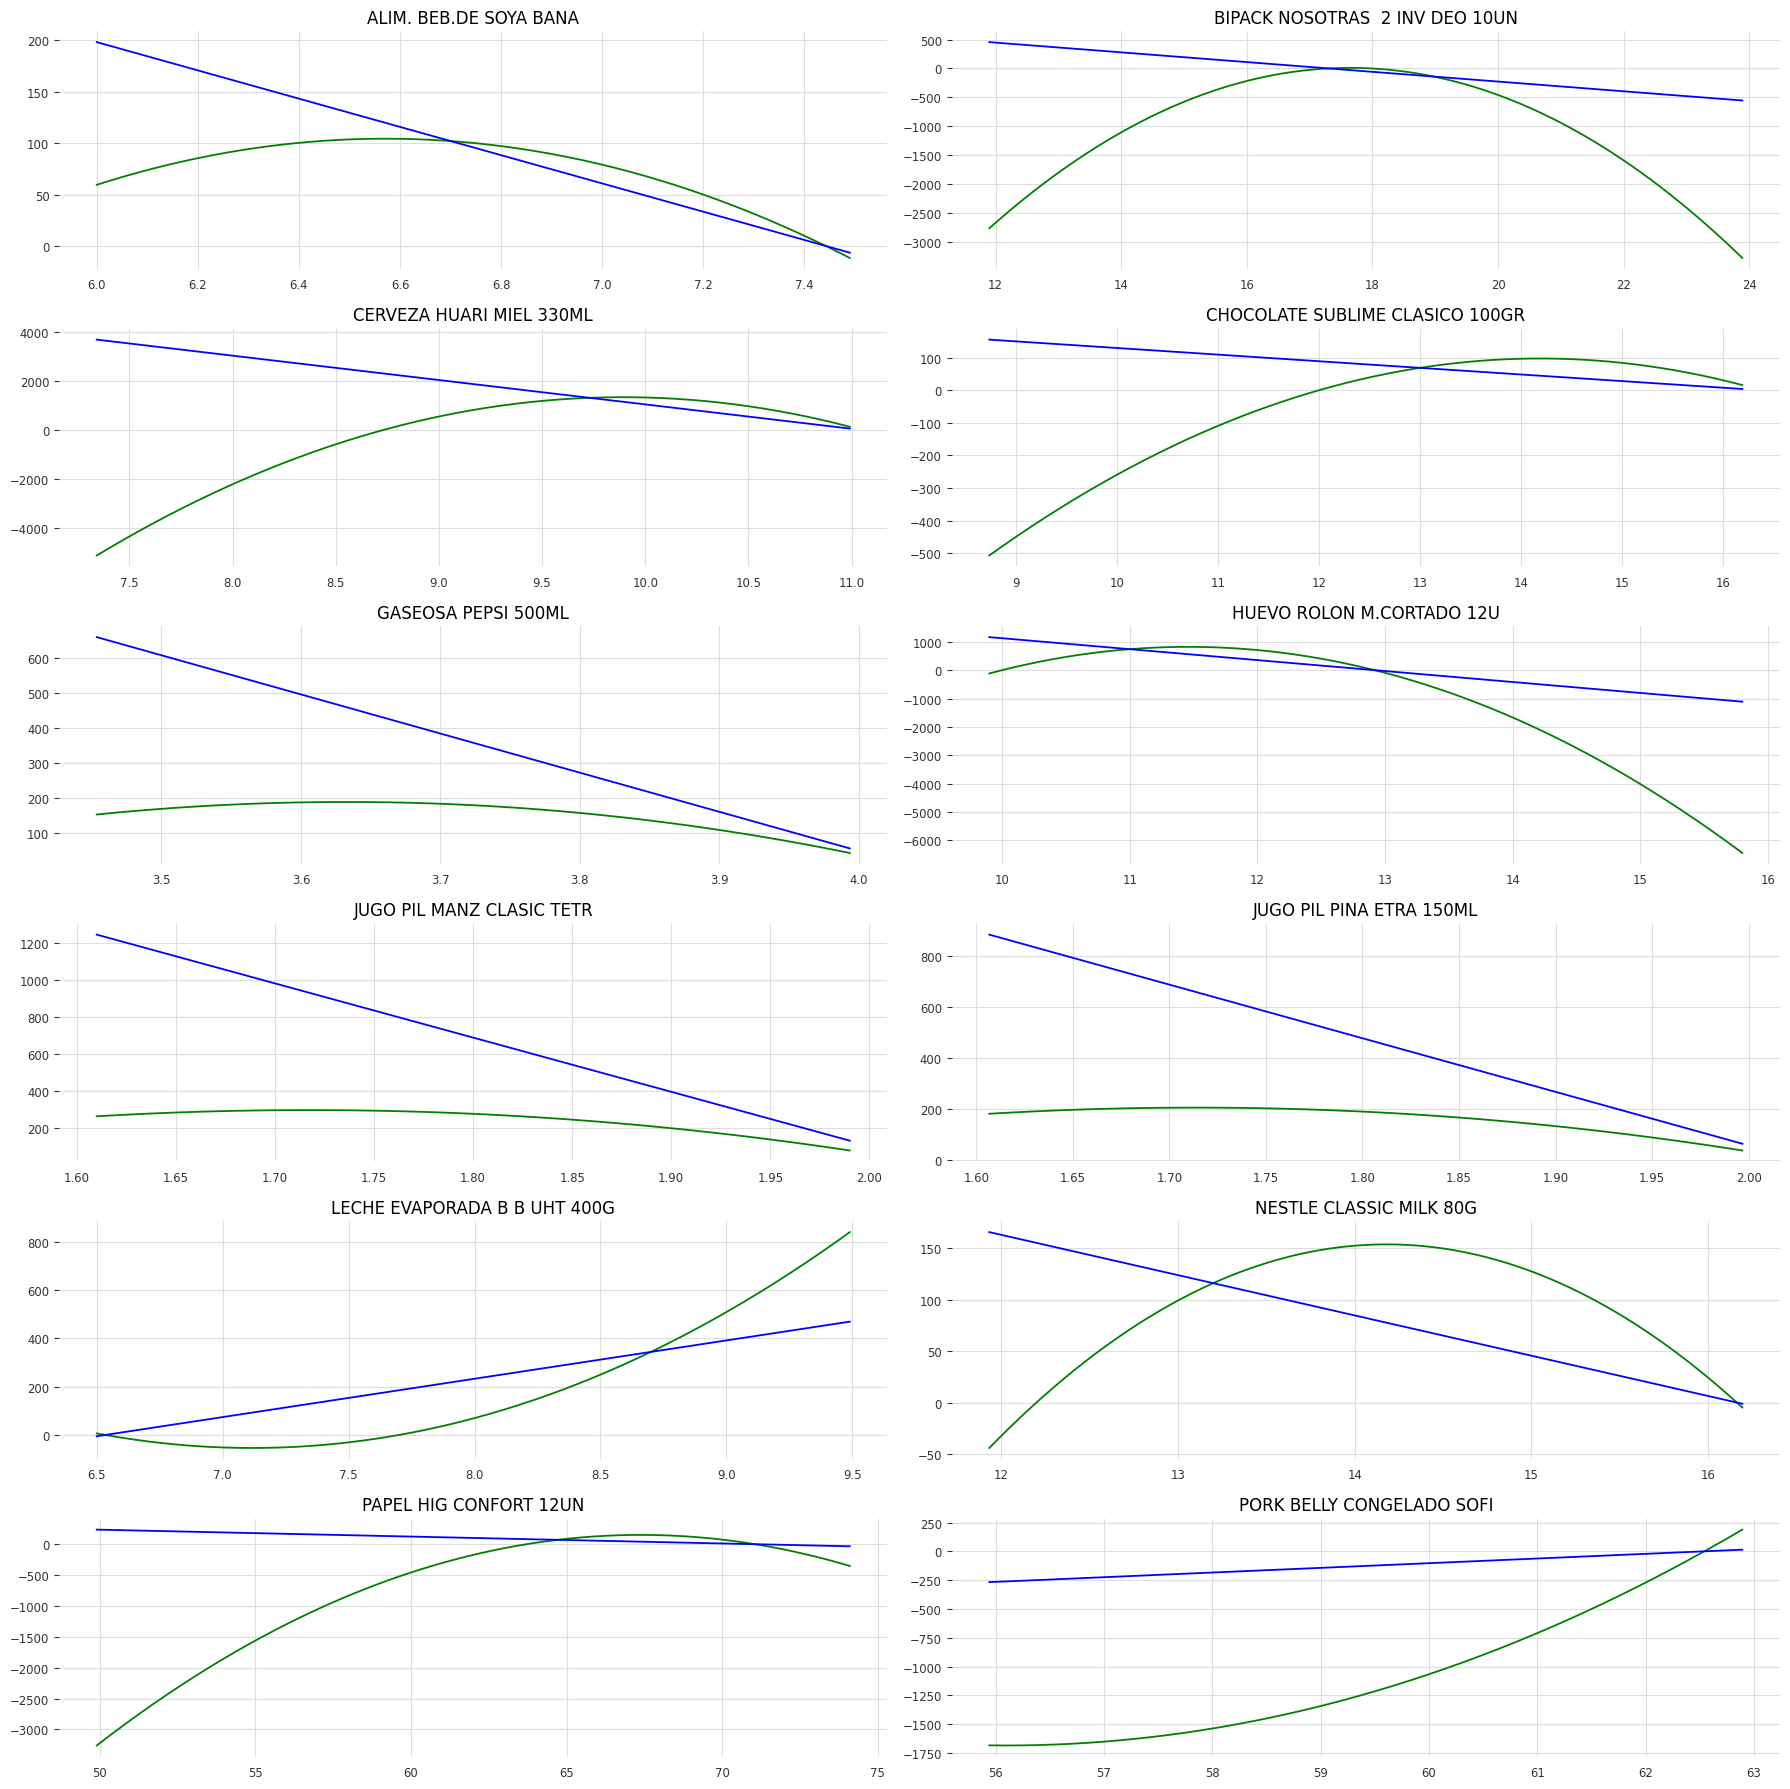

In [10]:
# 4.2 Show quantity and profit curves
plt.figure(figsize=(18, 18))
for i, k in enumerate(predictions):
    plt.subplot(6,2,i+1)
    demand = predictions[k] 
    intercept = intercepts[k]
    elasticity = elasticities[k]
    df_temp = predict_quantity(product=k, df=df,elasticity=elasticity, intercept=intercept)
    plt.plot(df_temp['price_list'],df_temp['profit'],c='g')
    plt.plot(df_temp['price_list'],df_temp['quantity'],c='b')
    plt.title(k)
plt.tight_layout()
plt.show() 

Las curvas de profit y cantidad nos permiten hallar el punto óptimo de 
ganancia dada una cantidad o al menos la zona donde la cantidad y la 
ganancia son positivas. Sin embargo, en los casos del pork belly o la 
leche evaporada hay que actuar con precaución, dado que las curvas de 
ganancia tienen crecimiento sin límites, lo cual se derivó de solo 
aplicar la relacion precio demanda sin considerar otros factores (por 
ejemplo que la competencia se desabastecio)

In [11]:
# 4.3 Apply over all products
product_prediction = {}
pq = 0
for v,k in enumerate(predictions):
    demand = predictions[k] 
    intercept = intercepts[k]
    elasticity = elasticities[k]
    duff =predict_quantity(product=k, df=df,elasticity=elasticity, intercept=intercept)
    ind = np.where(duff['profit']==duff['profit'].max())[0][0]
    max_profit = duff.iloc[ind]
    print(f'Product: {k}')
    if max_profit.iloc[1] < 0:
        print(f'Think about a price strategy, product could not meet profit')
        pq += demand * costos[k]
    else:
        print(f'Best price: {max_profit.iloc[0]:.2f}')
        print(f'Best quantity: {max_profit.iloc[1]:.0f}')
        pq += max_profit.iloc[1] * max_profit.iloc[0]
print(f'Total de venta: {pq}')

Product: ALIM. BEB.DE SOYA BANA
Best price: 6.57
Best quantity: 120
Product: BIPACK NOSOTRAS  2 INV DEO 10UN
Think about a price strategy, product could not meet profit
Product: CERVEZA HUARI MIEL 330ML
Best price: 9.89
Best quantity: 1153
Product: CHOCOLATE SUBLIME CLASICO 100GR
Best price: 14.19
Best quantity: 44
Product: GASEOSA PEPSI 500ML
Best price: 3.63
Best quantity: 459
Product: HUEVO ROLON M.CORTADO 12U
Best price: 11.46
Best quantity: 563
Product: JUGO PIL MANZ CLASIC TETR
Best price: 1.72
Best quantity: 924
Product: JUGO PIL PINA ETRA 150ML
Best price: 1.72
Best quantity: 652
Product: LECHE EVAPORADA B B UHT 400G
Best price: 9.49
Best quantity: 469
Product: NESTLE CLASSIC MILK 80G
Best price: 14.18
Best quantity: 78
Product: PAPEL HIG CONFORT 12UN
Best price: 67.38
Best quantity: 41
Product: PORK BELLY CONGELADO SOFI
Best price: 62.89
Best quantity: 14
Total de venta: 34764.53154256835


Como conclusión se presenta las sugerencias de mejor precio y mejor 
cantidad y el total de venta para la semana 9. Nuevamente, este procedimiento 
tiene puntos de mejora, como incorporar inventario (no se puede vender 
lo que no se tiene), merma (similar problema), temporadas festivas (no se 
ha asumido un país en particular) o precios comparativos en la competencia.